# Transfer Learning with FaceNet

The goal of this notebook is to train a SVM classifier to identify known and unknown faces on Jetson

This notebook is a proof of concept to test the FaceNet model from https://github.com/nyoki-mtl/keras-facenet on Nividia Jetson TX2. 

The code and methods were inspired by
* https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
* https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

## Load Packages

In [1]:
# import the package needed
import os
from os import listdir
from os.path import join
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import pandas as pd
from keras.models import load_model
from keras.models import Sequential
import pathlib

import cv2
import numpy as np
import time
import joblib

# Not going to use MTCNN for face detection 
# since the dependency issue hasn't been resolved yet.
# from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


In [2]:
# define shared functions

def cal_distance(emb1, emb2):
    # calculate and return the Euclidean distance between two embeddings
    return np.sum(np.square(emb1 - emb2))

def cal_avg_embeddings(embs, labels):
    avg_embeddings = {}
    for iden in KNOWN_IDENTITIES:
        avg_embeddings[iden] = np.mean(embs[labels==iden], 
                                       axis = 0)
    return avg_embeddings

def get_identity_distance(embs, labels, avg_embs):
    # get the distance between the embedding means and 
    # the idividual embeddings
    identity_distances = {"same": [], "diff": []}
    for iden in KNOWN_IDENTITIES:
        for emb in embs[labels==iden]:
            dist = cal_distance(avg_embs[iden], emb)
            identity_distances["same"].append(dist)
        for emb in embs[labels=="unknown"]:
            dist = cal_distance(avg_embs[iden], emb)
            identity_distances["diff"].append(dist)
    return identity_distances

def adjust_preds(embeds, iden_preds, avg_embs, tau):
    # adjust the SVM predictions based on embbeding distance to avg embeddings
    adjusted_iden_preds = []
    for index in range(len(iden_preds)):
        iden = iden_preds[index]
        dist = cal_distance(embeds[index], avg_embs[iden])
        if dist < tau:
            adjusted_iden_preds.append(iden)
        else:
            adjusted_iden_preds.append("unknown")
    return adjusted_iden_preds

## Load Face Embeddings

In [3]:
args = {
    # Set input directory
    # The names of the subdirectories will be the class labels
    "input_dir":"data/embeddings_dlib/",
    "split_types":["train", "val", "test"],
}

In [4]:
# get embedding for train and test dataset

# load the embeddings
embeddings = {}
labels = {}

for split in args["split_types"]:
    file_path = join(args["input_dir"], f"{split}_embeddings.npz")
    data = np.load(file_path)
    x, y = data['arr_0'], data['arr_1']
    embeddings[split] = x
    labels[split] = y

KNOWN_IDENTITIES = np.unique(labels["train"][labels["train"]!="unknown"])

## Quick EDA

In [5]:
pd.value_counts(labels["train"])

unknown    479
erik       139
diana       97
dtype: int64

In [6]:
pd.value_counts(labels["val"])

unknown    158
diana       98
erik        23
dtype: int64

## Training Approach 1

In order to train our model to not just tell the people it should recognize apart but also categorize an unkown person as unknown, we need to have an unknown class where we have images of many faces of different races. We built the dataset with this class included.

__Unlike the tutorial from which we get the inspiration, we have to use an SVM with a nonlinear kernel (with all the unknown faces, the decision boundary is very complex).__

In [7]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(embeddings["train"])
valX = in_encoder.transform(embeddings["val"])
# label encode targets
out_encoder_1 = LabelEncoder()
out_encoder_1.fit(labels["train"])
trainy = out_encoder_1.transform(labels["train"])
valy = out_encoder_1.transform(labels["val"])
# fit model
# Notice we are using different hyper params than the original tutorial
clf_1 = SVC(probability=True, class_weight='balanced')
# clf_1 = SVC(probability=True)
clf_1.fit(trainX, trainy)




SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
preds_1 = clf_1.predict(valX)

In [9]:
confusion_matrix(out_encoder_1.inverse_transform(valy), 
                 out_encoder_1.inverse_transform(preds_1), 
                 labels=list(out_encoder_1.classes_))

/usr/lib/python3/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 98,   0,   0],
       [  0,  23,   0],
       [  1,   2, 155]])

Looking at the output of the confusion matrix, we noticed that some unkown faces were incorrectly classified as known faces (in this case, 4 unkown faces were classified as **erik** and 4 unkown faces were classifie as **diana**). Let's take a look at them


Faces misclassified as Diana in the validation set


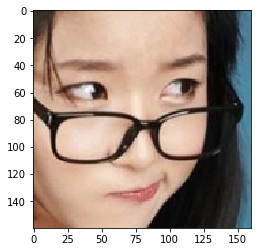

Faces misclassified as Erik in the validation set


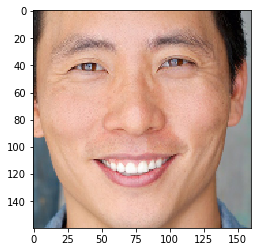

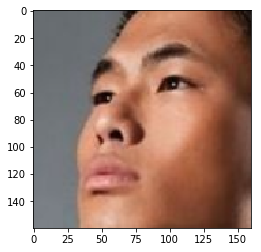

In [10]:
images = np.load("data/embeddings_dlib/val_faces.npz")

val_faces = images['arr_0']

misclf_diana = val_faces[(valy==2) * (preds_1==0)]
print("Faces misclassified as Diana in the validation set")
for face in misclf_diana:
    plt.imshow(face)
    plt.show()
    
misclf_erik = val_faces[(valy==2) * (preds_1==1)]
print("Faces misclassified as Erik in the validation set")
for face in misclf_erik:
    plt.imshow(face)
    plt.show()

We can see that the model gets confused when seeing images of the same gender and ethnicity. Though 3 cases out of 151 cases may seem like a small portion, it is not. Since the dataset were built to have diversity in mind, there are only about 20 images for Asian male and female each. Therefore, we could say out of the 20 Asian females the model saw, it confused 1 of them with **Diana**. Similarly for **Erik**, it was 2 out of 20. That's 10% and 5% respectively. It could be a problem if we care a lot about false positives.

This is behavior is not desired since the we really want the model to perform two functions:
* tell the difference between faces it should recognize
* correctly classify a face as unkown when it is in face an unknown face

However, not all mistakes are equal, if we pool all the known faces together and make the classification binary, we can have a higher tolerance for false negative(known predicted as unknown) than false postive (unknwon classified as known)

We will add another separate mechanism in our prediction process in order to prevent having false positives.

## Training Approach 2

From the above observation, we found that the model is good at distinguishing known faces but struggle a bit at classifying unkown faces as unknown. To address this issue, we could try to establish a threshold of likeness, $\tau$ for classifying a face as one of the known ones. Since the FaceNet was trained to arraged similar faces closer together in the high-dimensional space, we can simply get this threshold using the Euclidean distance as a metric. The strategy is to get the mean of all the embeddings of a known identity in the training set and any image needs to be closer to the mean than $\tau$ to be classified as the idenitty; otherwise, it will be labeled as unknown. 

### Proof of Concept

Let's quickly look at the training data and see if the concept of distance threshold will work

In [11]:
# get mean embeddings for the known identities
avg_embeddings = cal_avg_embeddings(embeddings["train"], labels["train"])

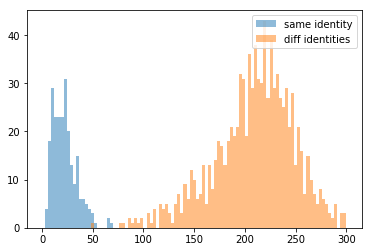

In [12]:
iden_distances = get_identity_distance(embeddings["train"], labels["train"], avg_embeddings)
iden_distances_val = get_identity_distance(embeddings["val"], labels["val"], avg_embeddings)

bins = np.linspace(0, 300, 100)
plt.hist(iden_distances["same"], bins, alpha=0.5, label="same identity")
plt.hist(iden_distances["diff"], bins, alpha=0.5, label="diff identities")
plt.legend(loc='upper right')
plt.show()

Looking at the above graph, we see hope!!! We can see a natural threshold at around 55 unit of distance. As least for the training set, if we categorize every unknown images as unknown and may just have two false negatives where known faces are classified as unknown. Just to be safe, let's look at those false negatives.

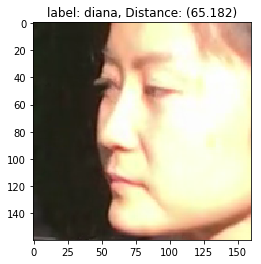

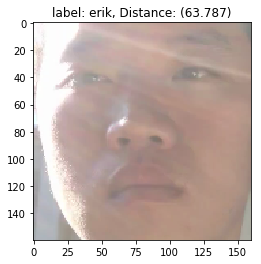

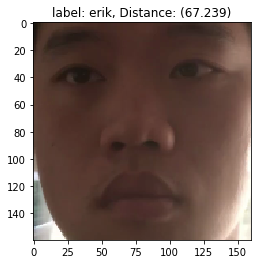

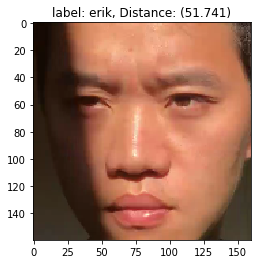

In [13]:
images = np.load("data/embeddings_dlib/train_faces.npz")
train_labels = labels["train"]
train_embs = embeddings["train"]
train_faces = images['arr_0']

for iden in KNOWN_IDENTITIES:
    for index in range(len(train_labels)):
        if iden != train_labels[index]:
            continue
        emb = train_embs[index]
        dist = cal_distance(avg_embeddings[iden], emb)
        if dist > 50:
            plt.imshow(train_faces[index])
            title = 'label: %s, Distance: (%.3f)' % (iden, dist)
            plt.title(title)
            plt.show()

We can see that the reason why these 4 images have long distance to the mean is probably due to poor quality caused by too much light or shadow or sideview.

Since we've proven the concept, we can try it on the validation data with $\tau$ = the minimum distance between the unknown identities and any mean of a known identity. Let's look at the image associated $\tau$

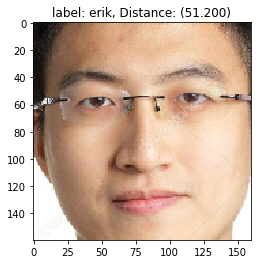

In [14]:
for iden in KNOWN_IDENTITIES:
    for index in range(len(train_labels)):
        if train_labels[index] != "unknown":
            continue
        emb = train_embs[index]
        dist = cal_distance(avg_embeddings[iden], emb)
        if dist == np.min(iden_distances["diff"]):
            plt.imshow(train_faces[index])
            title = 'label: %s, Distance: (%.3f)' % (iden, dist)
            plt.title(title)
            plt.show()

### Training

#### Set $\tau$

In [15]:
tau_2 = np.min(iden_distances["diff"])
print(tau_2)

51.199623


#### Train Model
Notice since we are using $\tau$ to determine whether a face is known or not, we don't need the unkown example in the training of our SVM anymore. Instead, we can simply train an SVM to find a most "similar" identity for a given face and then use $\tau$ to ultimately decide whether we will use the label predicted by the SVM classifier or to say it's an unknown face.

In [16]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(embeddings["train"][train_labels!="unknown"])
valX = in_encoder.transform(embeddings["val"])
# label encode targets
out_encoder_2 = LabelEncoder()
out_encoder_2.fit(labels["train"][train_labels!="unknown"])
trainy = out_encoder_2.transform(labels["train"][train_labels!="unknown"])
# fit model
clf_2 = SVC(class_weight='balanced')
clf_2.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Evaluate on the Validation Set

In [17]:
preds_2 = clf_2.predict(valX)
pred_identities = out_encoder_2.inverse_transform(preds_2)

adjusted_pred_identities = adjust_preds(embeddings["val"], pred_identities, avg_embeddings, tau_2)

/usr/lib/python3/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
confusion_matrix(labels["val"], 
                 adjusted_pred_identities)

array([[ 94,   0,   4],
       [  0,  20,   3],
       [  0,   0, 158]])

Good news! The incorportaion of the distance theshold successfully push the 3 unknown faces that were previously incorrectly identitfied as **erik** or **diana** back to the correct label, **unknown**. Also, there is some sacrifice for this additional step since there are some known faces being classified as unknown. Let's look at them:

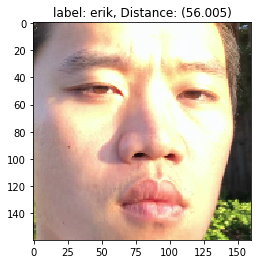

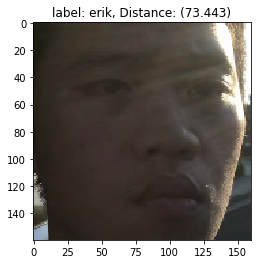

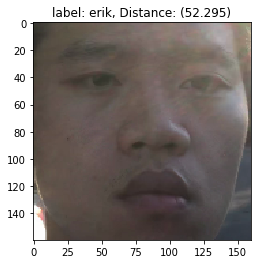

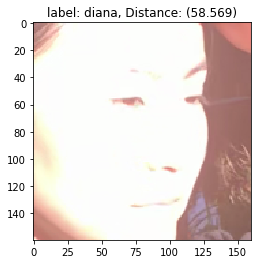

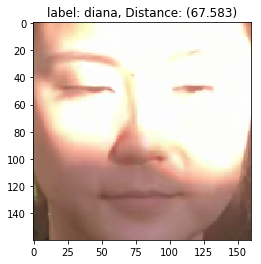

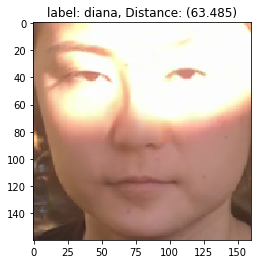

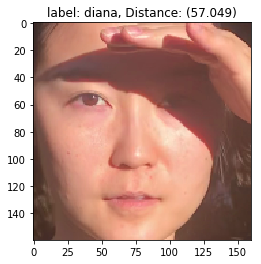

In [19]:
for face, emb, pred, iden in zip(val_faces, embeddings["val"], adjusted_pred_identities, labels["val"]):
    if pred != iden and iden != "unknown":
        plt.imshow(face)
        dist = cal_distance(emb, avg_embeddings[iden])
        title = 'label: %s, Distance: (%.3f)' % (iden, dist)
        plt.title(title)
        plt.show()

Phew! We can have a peace of mind since these are tough examples where the lighting makes the faces a lot harder to distinguish. Also, the FaceNet still generated decent embeddings that are very close to the threshold! 

**One thing I didn't mention is that when recording for the validation set, I purposely recorded the video various situation where the lightings are tough to test the models ability**

As long as our model didn't miss the easy and normal cases that it should correctly classify, it is satisfactory. We can proceed.

Just as the last confirmation, let's calculate the 3 previously incorrectly classified validation example's distances and see how far they are from $\tau$

Faces misclassified as Diana in the val set by model 1


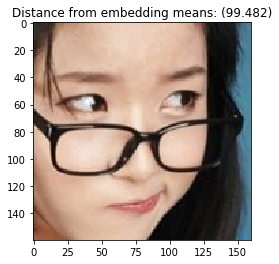

Faces misclassified as Erik in the val set by model 1


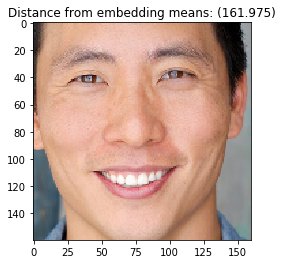

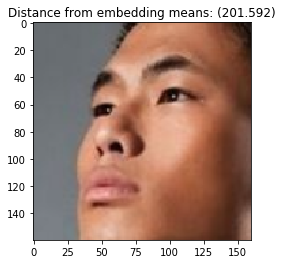

In [20]:

misclf_diana_embs = embeddings["val"][(valy==2) * (preds_1==0)]
print("Faces misclassified as Diana in the val set by model 1")
for i in range(len(misclf_diana)):
    plt.imshow(misclf_diana[i])
    dist = cal_distance(avg_embeddings["diana"],misclf_diana_embs[i])
    title = 'Distance from embedding means: (%.3f)' %dist
    plt.title(title)
    plt.show()
    
misclf_erik_embs = embeddings["val"][(valy==2) * (preds_1==1)]
print("Faces misclassified as Erik in the val set by model 1")
for i in range(len(misclf_erik)):
    plt.imshow(misclf_erik[i])
    dist = cal_distance(avg_embeddings["diana"],misclf_erik_embs[i])
    title = 'Distance from embedding means: (%.3f)' %dist
    plt.title(title)
    plt.show()

## Training with Approach 3

In this last approach, we will explore fine-tuning the FaceNet model with the it's top 2 layers unfrozen and see whether we can make it more specialized in producing effective embeddings for our case (i.e., make all the known identity embeddings closer together and the unknown ones farther away from the known ones). The model has been fine-tuned and we have used it to generate a new set of embedding. Now, we will see whether these embeddings are better and easier to classify. Alright, let's go to work!

### Load Data

After tuning the FaceNet model, we used the data-preprocessing script to generate the embeddings using the newly tuned model. Now let's load them in.

In [21]:
# Load the embeddings encoded by the fine-tuned FaceNet
args = {
    # Set input directory
    # The names of the subdirectories will be the class labels
    "input_dir":"data/embeddings_dlib_tuned/",
    "split_types":["train", "val", "test"]
}

# get embedding for train and test dataset
# load the embeddings
embeddings = {}
labels = {}

for split in args["split_types"]:
    file_path = join(args["input_dir"], f"{split}_embeddings.npz")
    data = np.load(file_path)
    x, y = data['arr_0'], data['arr_1']
    embeddings[split] = x
    labels[split] = y

### Check the distances of embedings to known identities

Now, let's check the distances of face embeddings to the avg embeddings of the known identities, and compare them with those before fine-tuning FaceNet.

In [22]:
# recalculate avg embeddins again
avg_embeddings_tuned = cal_avg_embeddings(embeddings["train"], labels["train"])

In [23]:
# get distances to known identities
iden_distances_tuned = get_identity_distance(embeddings["train"], labels["train"], avg_embeddings_tuned)

#### Training Set Distance Comparison

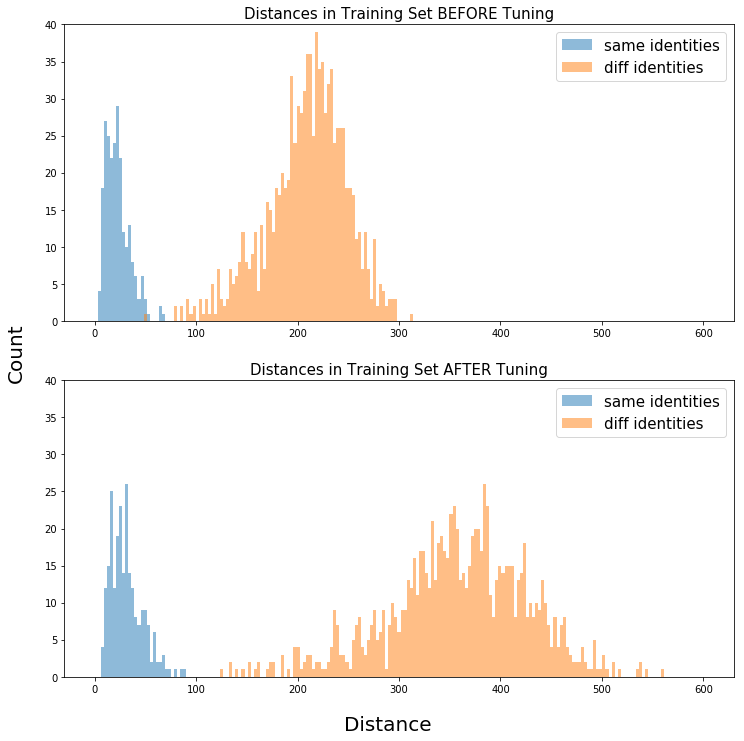

In [24]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

bins = np.linspace(0, 600, 200)

ax1.hist(iden_distances["same"], bins, alpha=0.5, label="same identities")
ax1.hist(iden_distances["diff"], bins, alpha=0.5, label="diff identities")
ax2.hist(iden_distances_tuned["same"], bins, alpha=0.5, label="same identities")
ax2.hist(iden_distances_tuned["diff"], bins, alpha=0.5, label="diff identities")

# Set common labels
fig.text(0.5, 0.07, 'Distance', ha='center', va='center', fontsize=20)
fig.text(0.07, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)

ax1.set_title('Distances in Training Set BEFORE Tuning', fontsize=15)
ax2.set_title('Distances in Training Set AFTER Tuning', fontsize=15)

ax1.set_ylim([0, 40])
ax2.set_ylim([0, 40])

ax1.legend(loc="upper right", fontsize=15)
ax2.legend(loc="upper right", fontsize=15)

plt.show()

Alright! We see good news. After the tuning, the unkown faces were pushed further away from the known faces. We don't have an overlap now. However, this doesn't gaurantee success when making inference in the validation set since the we used the training set to tune the FaceNet model. So lets test on the validation set and analyze the result.

### Train the Model

In [25]:
# set tau
tau_3 = np.min(iden_distances_tuned["diff"])
print(tau_3)

123.66597


In [26]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(embeddings["train"][labels["train"]!="unknown"])
# label encode targets
out_encoder_3 = LabelEncoder()
out_encoder_3.fit(labels["train"][labels["train"]!="unknown"])
trainy = out_encoder_3.transform(labels["train"][labels["train"]!="unknown"])
# fit model
# Notice we are using different hyper params than the original tutorial
clf_3 = SVC(probability=True, class_weight='balanced')
# clf_1 = SVC(probability=True)
clf_3.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Evaluate on the Validation Set

In [27]:
valX = in_encoder.transform(embeddings["val"])
preds_3 = clf_3.predict(valX)
pred_identities = out_encoder_3.inverse_transform(preds_3)

adjusted_pred_identities = adjust_preds(embeddings["val"], pred_identities, avg_embeddings_tuned, tau_3)

/usr/lib/python3/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [28]:
confusion_matrix(labels["val"], 
                 adjusted_pred_identities)

array([[ 98,   0,   0],
       [  0,  23,   0],
       [  0,   0, 158]])

WOW!! We did perfect on the validation set. This is good. Let's look at the distance graph on the validation set and see how well the tuned FaceNet encode the faces it has not seen before.

In [29]:
# get distances to known identities
iden_distances_val_tuned = get_identity_distance(embeddings["val"], labels["val"], avg_embeddings_tuned)

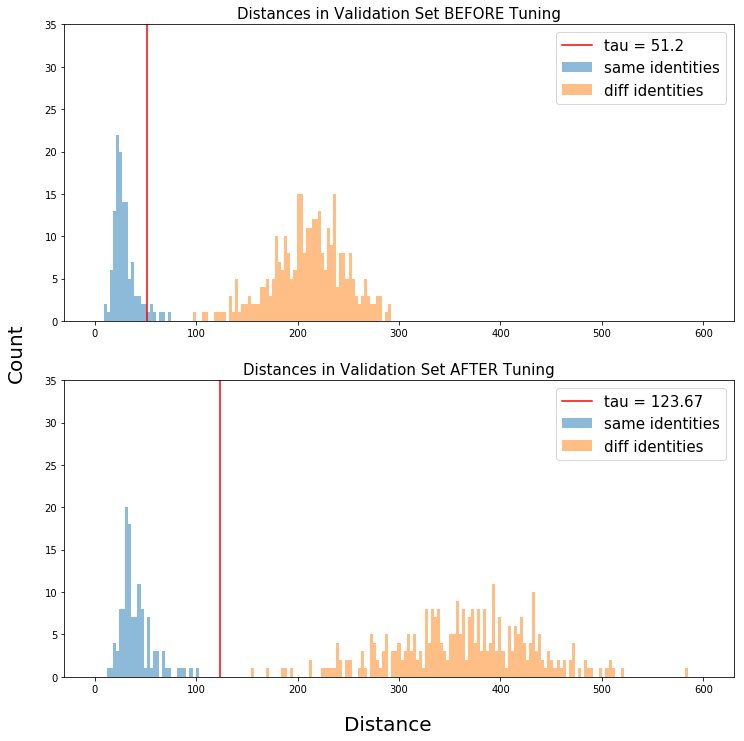

In [30]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

bins = np.linspace(0, 600, 200)

ax1.hist(iden_distances_val["same"], bins, alpha=0.5, label="same identities")
ax1.hist(iden_distances_val["diff"], bins, alpha=0.5, label="diff identities")
ax2.hist(iden_distances_val_tuned["same"], bins, alpha=0.5, label="same identities")
ax2.hist(iden_distances_val_tuned["diff"], bins, alpha=0.5, label="diff identities")

# Set common labels
fig.text(0.5, 0.07, 'Distance', ha='center', va='center', fontsize=20)
fig.text(0.07, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)

ax1.set_title('Distances in Validation Set BEFORE Tuning', fontsize=15)
ax2.set_title('Distances in Validation Set AFTER Tuning', fontsize=15)

ax1.axvline(x=tau_2, label='tau = {}'.format(str(round(tau_2,2))), c='r')
ax2.axvline(x=tau_3, label='tau = {}'.format(str(round(tau_3,2))), c='r')

ax1.set_ylim([0, 35])
ax2.set_ylim([0, 35])

ax1.legend(loc="upper right", fontsize=15)
ax2.legend(loc="upper right", fontsize=15)

plt.show()

Cool! I think approach 3 of fine-tuning FaceNet worked! Let's save the models and move on the live testing.

## Save the models

### Save Model from Approach 1

In [31]:
# joblib.dump(clf_1, "trained-models/face_classifier_1.joblib")
# joblib.dump(out_encoder_1, "trained-models/face_label_encoder_1.joblib")

### Save Model from Approach 2 

In [32]:
joblib.dump(clf_2, "trained-models/face_classifier_2.joblib")
joblib.dump(out_encoder_2, "trained-models/face_label_encoder_2.joblib")
joblib.dump(avg_embeddings, "trained-models/avg_embeddings_2.joblib")
joblib.dump(tau_2, "trained-models/tau_2.joblib")

['trained-models/tau_2.joblib']

### Save Model from Approach 3

In [33]:
joblib.dump(clf_3, "trained-models/face_classifier_3.joblib")
joblib.dump(out_encoder_3, "trained-models/face_label_encoder_3.joblib")
joblib.dump(avg_embeddings_tuned, "trained-models/avg_embeddings_3.joblib")
joblib.dump(tau_3, "trained-models/tau_3.joblib")

['trained-models/tau_3.joblib']